In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from unet3d import Unet3D
from diffuser import GaussianDiffusion
from data import NaiverStokes_Dataset

In [2]:
ds = NaiverStokes_Dataset('../data/ns_data_T20_v1e-03_N200.mat')

Loaded 200 samples from ../data/ns_data_T20_v1e-03_N200.mat
Shape of x: torch.Size([200, 1, 20, 64, 64])


### Visualization of the Physical Process

In [3]:
x_range = torch.linspace(0, 1, 64+1)[:-1]
y_range = torch.linspace(0, 1, 64+1)[:-1]
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')

In [17]:
w0 = ds.a.squeeze()
w_traj = ds.w_now.squeeze()
w0.shape, w_traj.shape

(torch.Size([200, 64, 64]), torch.Size([200, 20, 64, 64]))

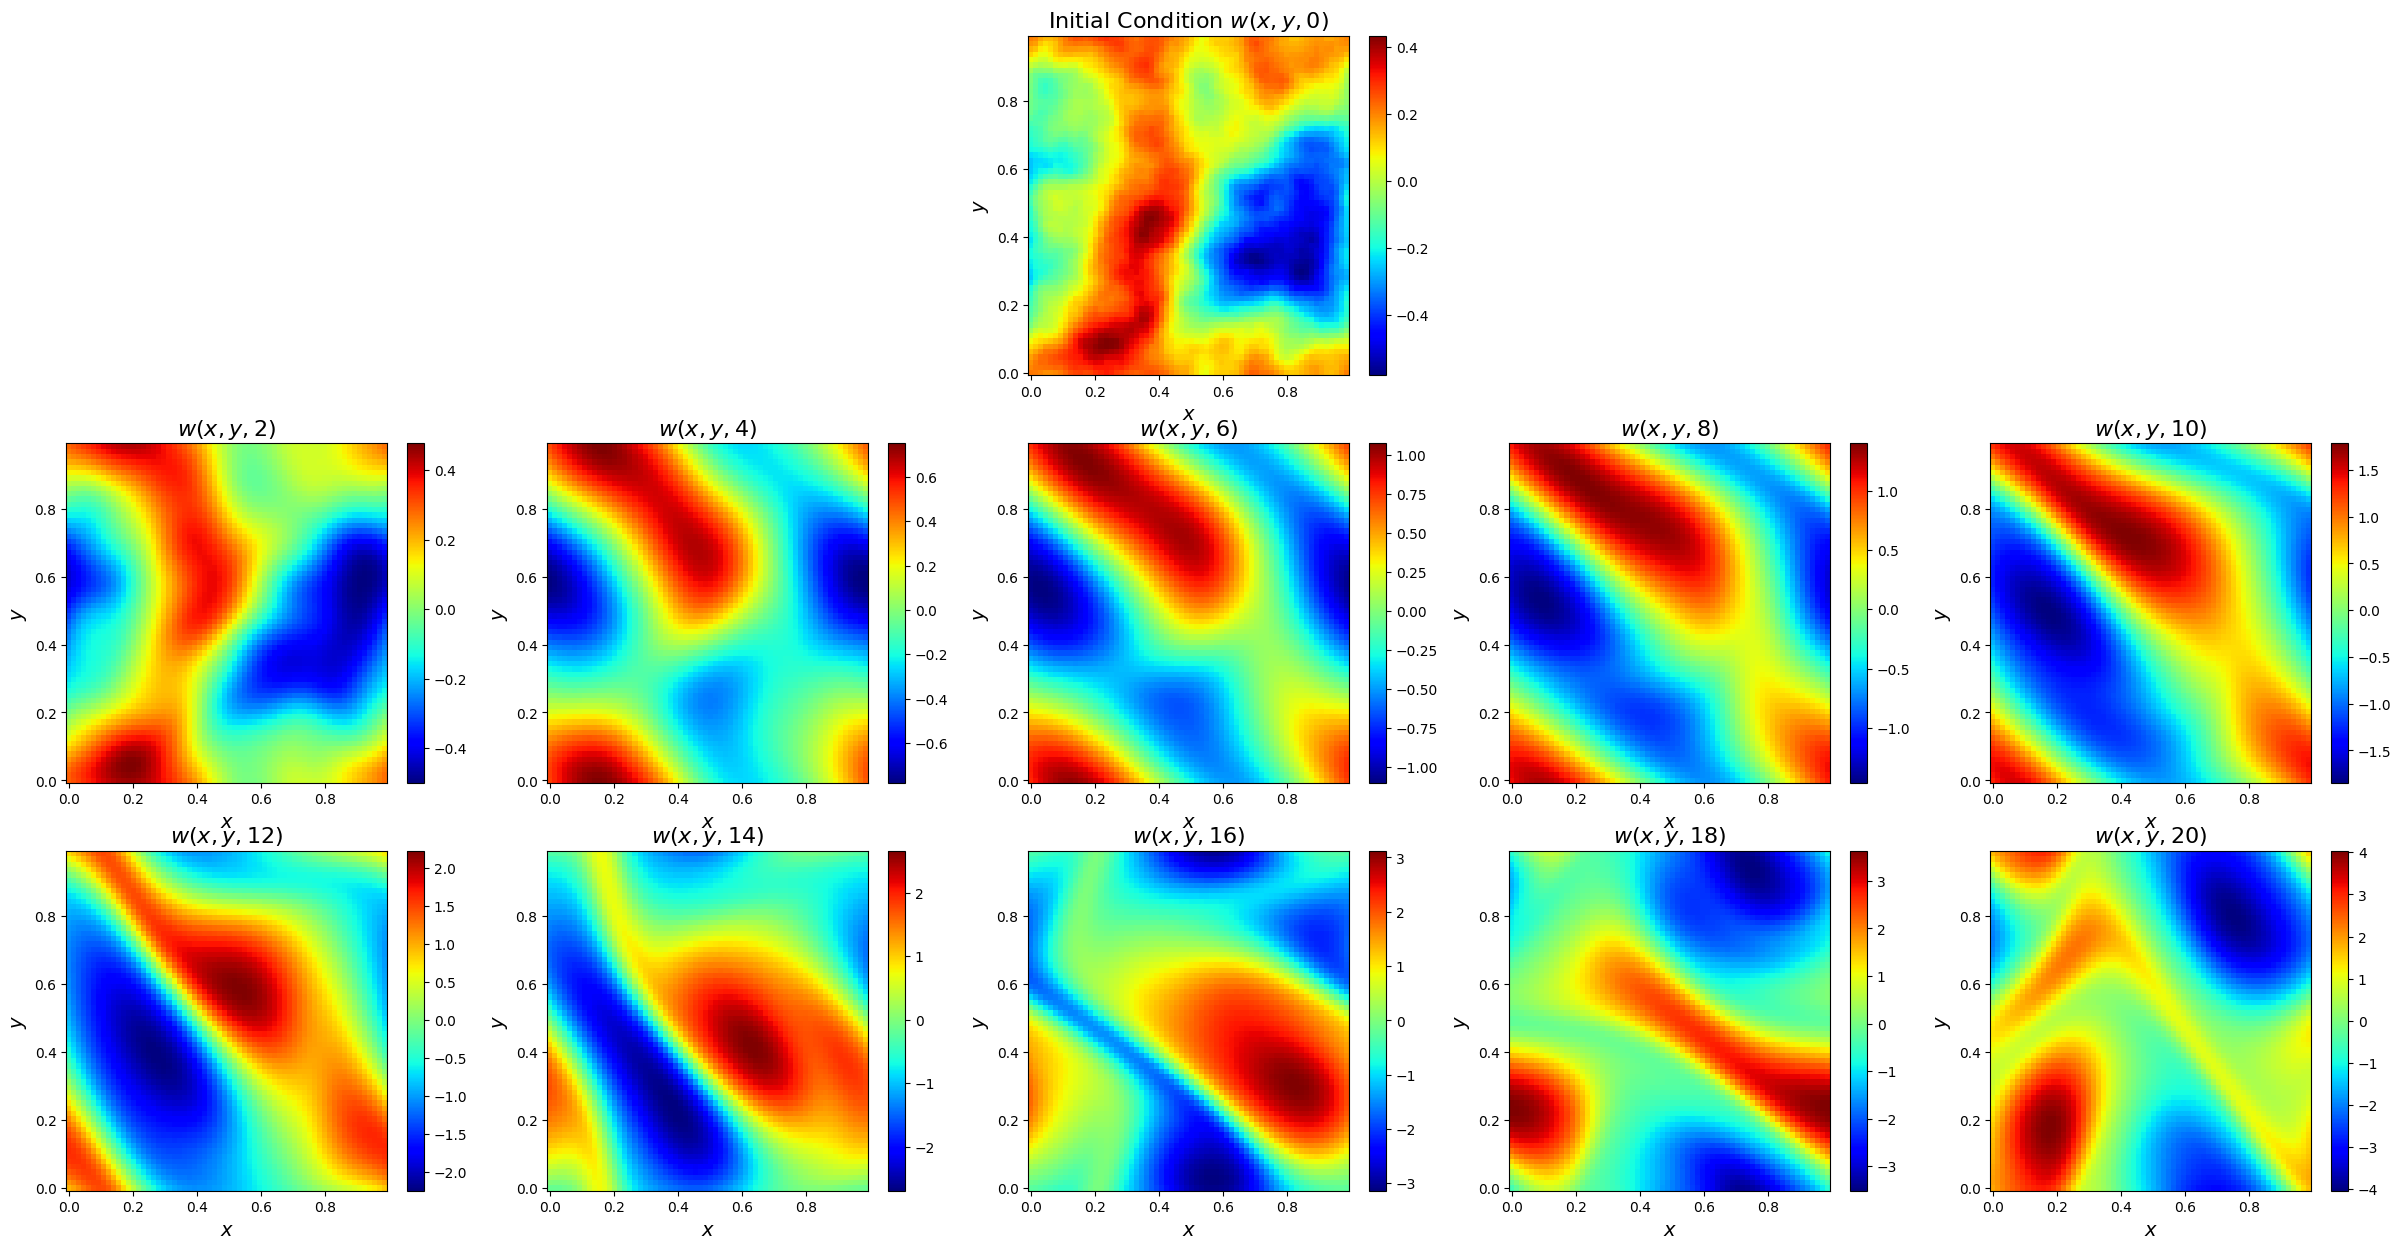

In [10]:
# norm = matplotlib.colors.Normalize(vmin=w_traj.min().item(), vmax=w_traj.max().item())
fig, ax = plt.subplots(3, 5, figsize=(30, 15))
im1 = ax[0, 2].pcolormesh(X, Y, w0, cmap='jet')
ax[0, 2].set_xlabel('$x$', fontsize=14)
ax[0, 2].set_ylabel('$y$', fontsize=14)
ax[0, 2].set_title('Initial Condition $w(x, y, 0)$', fontsize=16)
fig.colorbar(im1, ax=ax[0, 2])

ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 3].set_axis_off()
ax[0, 4].set_axis_off()

for i in range(5):
    im2 = ax[1, i].pcolormesh(X, Y, w_traj[i*2+1], cmap='jet')
    ax[1, i].set_xlabel('$x$', fontsize=14)
    ax[1, i].set_ylabel('$y$', fontsize=14)
    ax[1, i].set_title(f'$w(x, y, {i*2+2})$', fontsize=16)
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, w_traj[i*2+11], cmap='jet')
    ax[2, i].set_xlabel('$x$', fontsize=14)
    ax[2, i].set_ylabel('$y$', fontsize=14)
    ax[2, i].set_title(f'$w(x, y, {i*2+12})$', fontsize=16)
    fig.colorbar(im3, ax=ax[2, i])

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)

In [11]:
fig.savefig('../assets/ns/ns_visualization.png', dpi=300, bbox_inches='tight')

### Model Test

In [4]:
model = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8, 16),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    model=model,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    sampling_timesteps=1000,
    objective='pred_x0',
    physics_loss_weight=1.0
)
diffuser = diffuser.to('cuda:0')

In [5]:
def make_prediction(diffusion_model, cond, physics_loss_weight, error_calibration=False):
    if error_calibration and physics_loss_weight > 0.0:
        weights = torch.load(f"../ckpts/ddpm/ns_{physics_loss_weight:.2f}phyloss(ec)/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
    else:
        weights = torch.load(f"../ckpts/ddpm/ns_{physics_loss_weight:.2f}phyloss/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
    diffusion_model.model.load_state_dict(weights)
    x_pred = diffusion_model.sample(cond=cond)

    return x_pred.cpu().numpy().squeeze()

In [35]:
x = ds[20:21]['x']
y = ds[20:21]['y']

In [38]:
x_pred010_ec = make_prediction(diffuser, y, 0.10, error_calibration=True)

DDPM sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


In [39]:
x = x.squeeze()
y = y.squeeze()

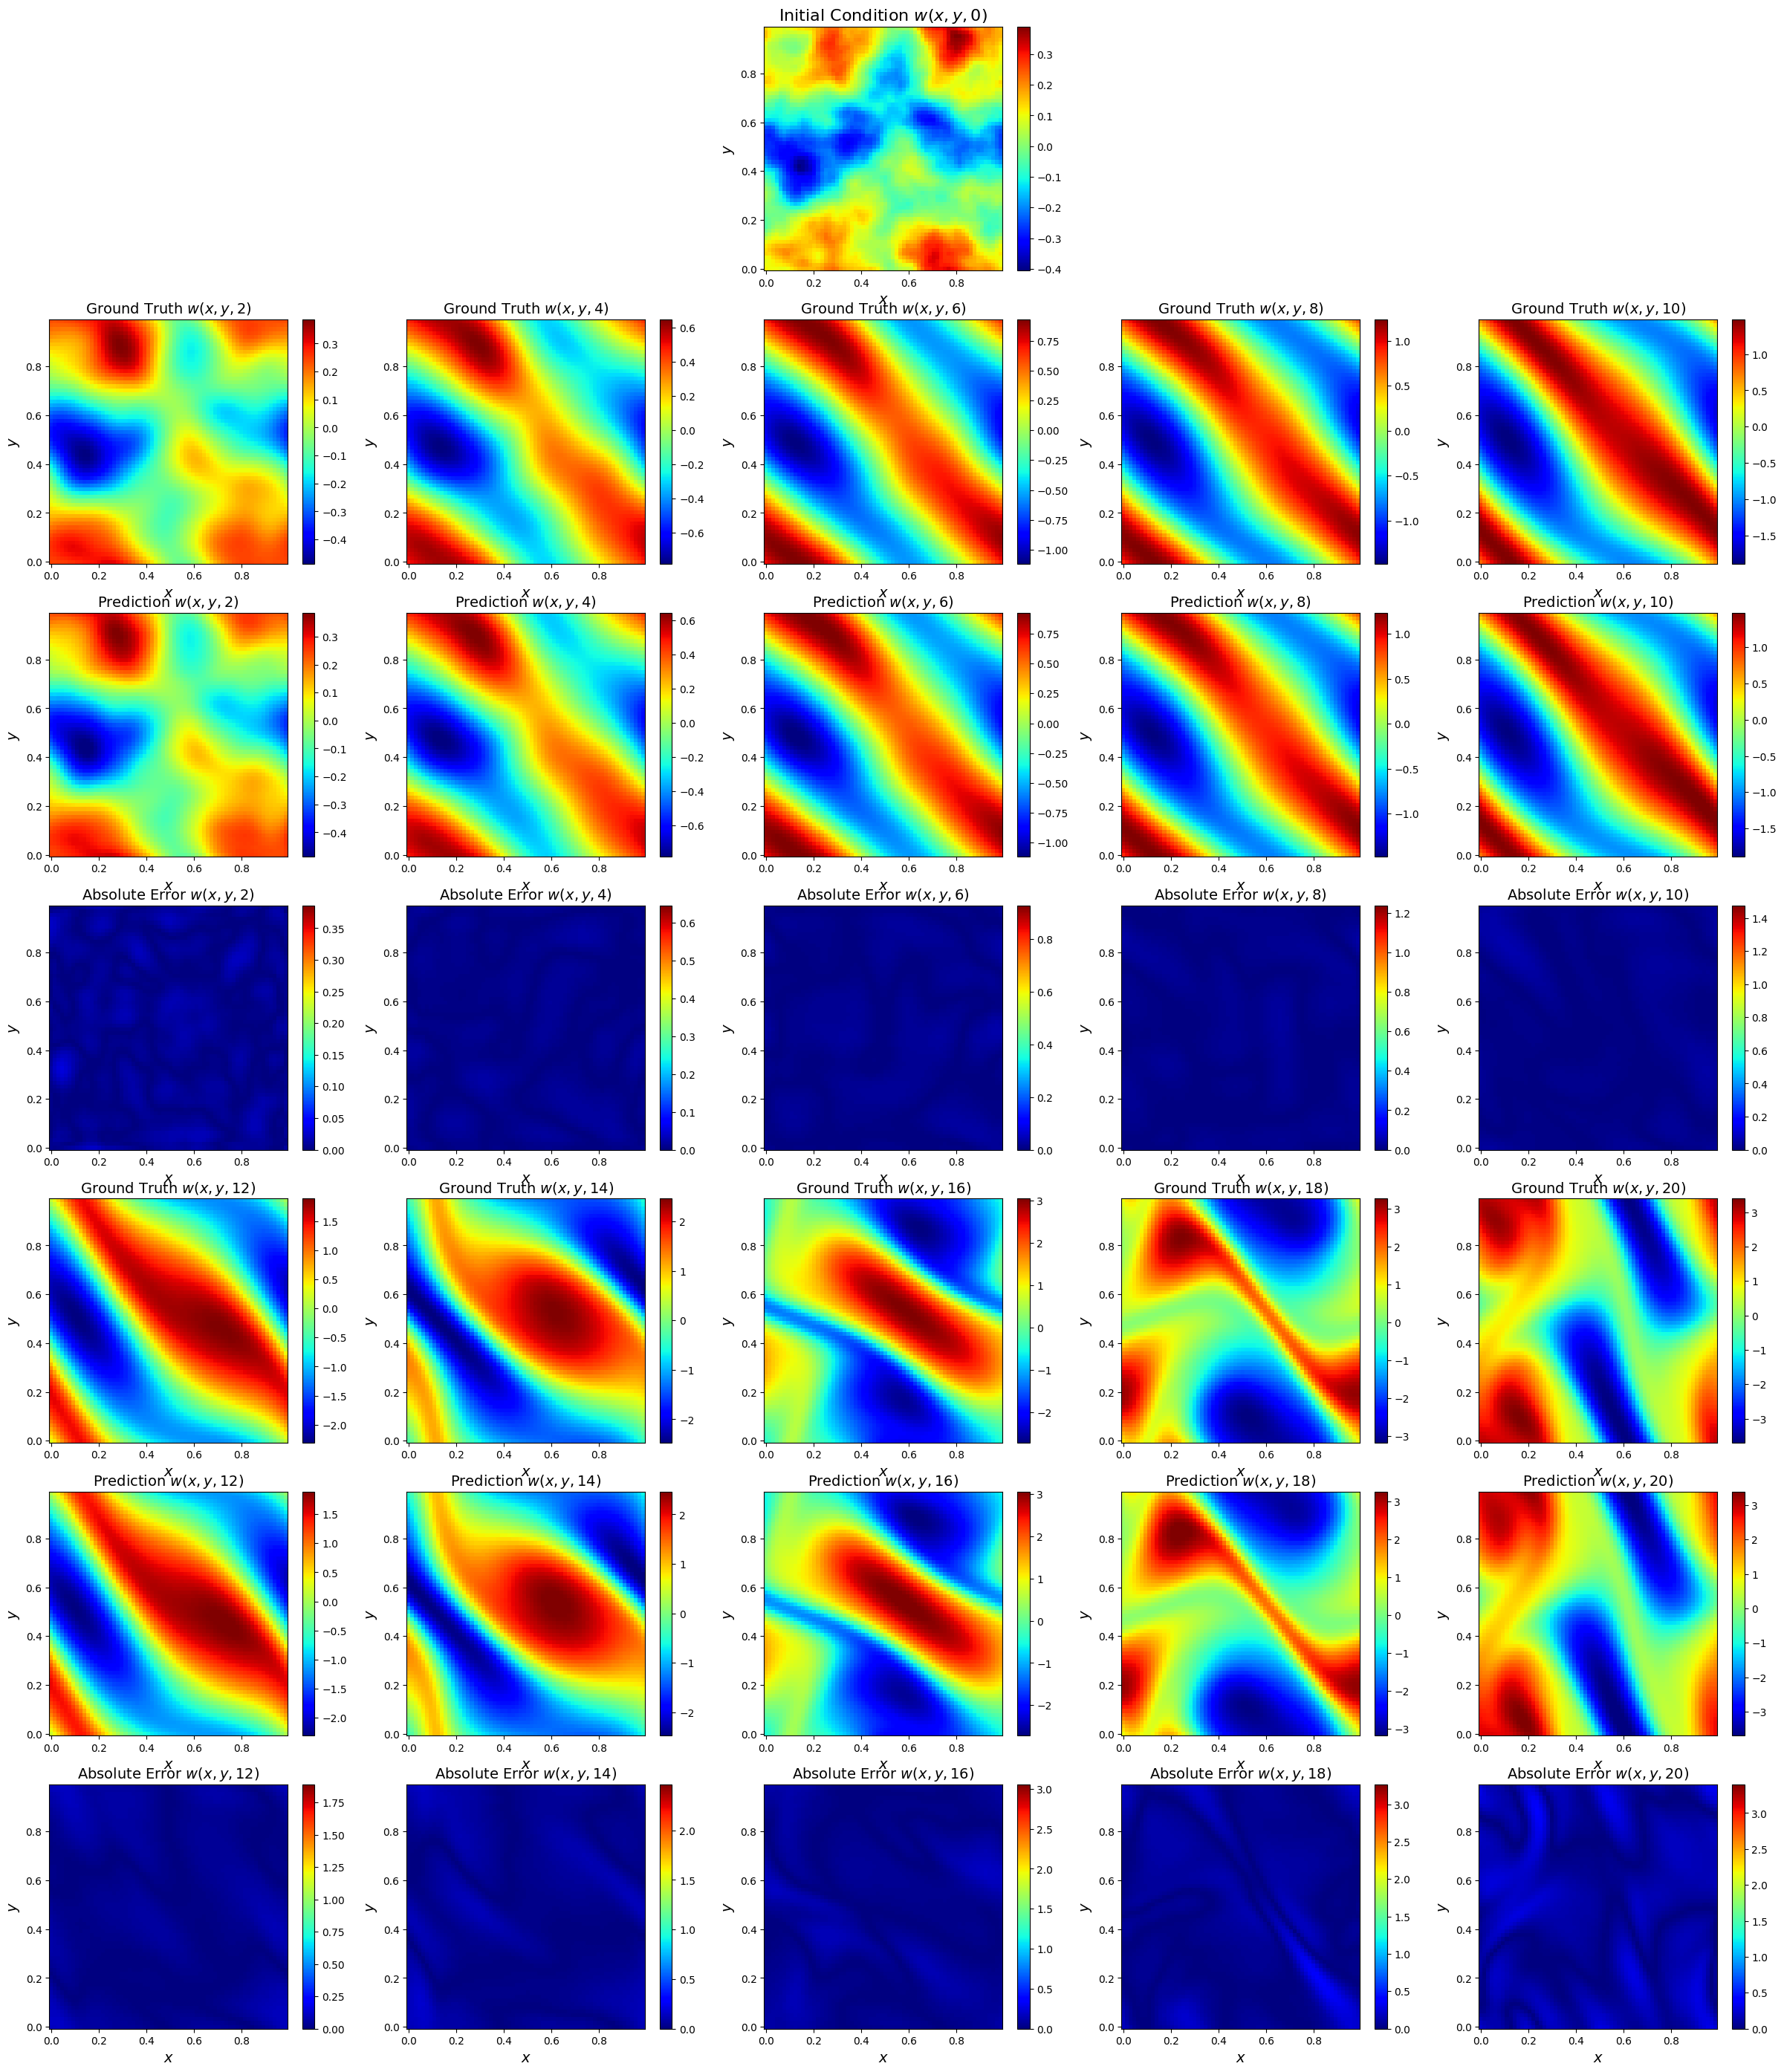

In [45]:
fig, ax = plt.subplots(7, 5, figsize=(30, 35))
im1 = ax[0, 2].pcolormesh(X, Y, y, cmap='jet')
ax[0, 2].set_xlabel('$x$', fontsize=14)
ax[0, 2].set_ylabel('$y$', fontsize=14)
ax[0, 2].set_title('Initial Condition $w(x, y, 0)$', fontsize=16)
fig.colorbar(im1, ax=ax[0, 2])

ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 3].set_axis_off()
ax[0, 4].set_axis_off()

for i in range(5):
    norm1 = matplotlib.colors.Normalize(vmin=x[i*2+1].min(), vmax=x[i*2+1].max())
    im2 = ax[1, i].pcolormesh(X, Y, x[i*2+1], cmap='jet', norm=norm1)
    ax[1, i].set_xlabel('$x$', fontsize=14)
    ax[1, i].set_ylabel('$y$', fontsize=14)
    ax[1, i].set_title(f'Ground Truth $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, x_pred010_ec[i*2+1], cmap='jet', norm=norm1)
    ax[2, i].set_xlabel('$x$', fontsize=14)
    ax[2, i].set_ylabel('$y$', fontsize=14)
    ax[2, i].set_title(f'Prediction $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im3, ax=ax[2, i])

    norm2 = matplotlib.colors.Normalize(vmin=0, vmax=x[i*2+1].max())
    im4 = ax[3, i].pcolormesh(X, Y, np.abs(x[i*2+1] - x_pred010_ec[i*2+1]), cmap='jet', norm=norm2)
    ax[3, i].set_xlabel('$x$', fontsize=14)
    ax[3, i].set_ylabel('$y$', fontsize=14)
    ax[3, i].set_title(f'Absolute Error $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im4, ax=ax[3, i])

    norm3 = matplotlib.colors.Normalize(vmin=x[i*2+11].min(), vmax=x[i*2+11].max())
    im5 = ax[4, i].pcolormesh(X, Y, x[i*2+11], cmap='jet', norm=norm3)
    ax[4, i].set_xlabel('$x$', fontsize=14)
    ax[4, i].set_ylabel('$y$', fontsize=14)
    ax[4, i].set_title(f'Ground Truth $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im5, ax=ax[4, i])

    im6 = ax[5, i].pcolormesh(X, Y, x_pred010_ec[i*2+11], cmap='jet', norm=norm3)
    ax[5, i].set_xlabel('$x$', fontsize=14)
    ax[5, i].set_ylabel('$y$', fontsize=14)
    ax[5, i].set_title(f'Prediction $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im6, ax=ax[5, i])

    norm4 = matplotlib.colors.Normalize(vmin=0, vmax=x[i*2+11].max())
    im7 = ax[6, i].pcolormesh(X, Y, np.abs(x[i*2+11] - x_pred010_ec[i*2+11]), cmap='jet', norm=norm4)
    ax[6, i].set_xlabel('$x$', fontsize=14)
    ax[6, i].set_ylabel('$y$', fontsize=14)
    ax[6, i].set_title(f'Absolute Error $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im7, ax=ax[6, i])

In [46]:
fig.savefig('../assets/ns/ns_prediction.png', dpi=300, bbox_inches='tight')

In [47]:
x = ds[120:122]['x']
y = ds[120:122]['y']

In [48]:
x_pred010_ec = make_prediction(diffuser, y, 0.10, error_calibration=True)

DDPM sampling: 100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


In [49]:
x = x.squeeze()
y = y.squeeze()

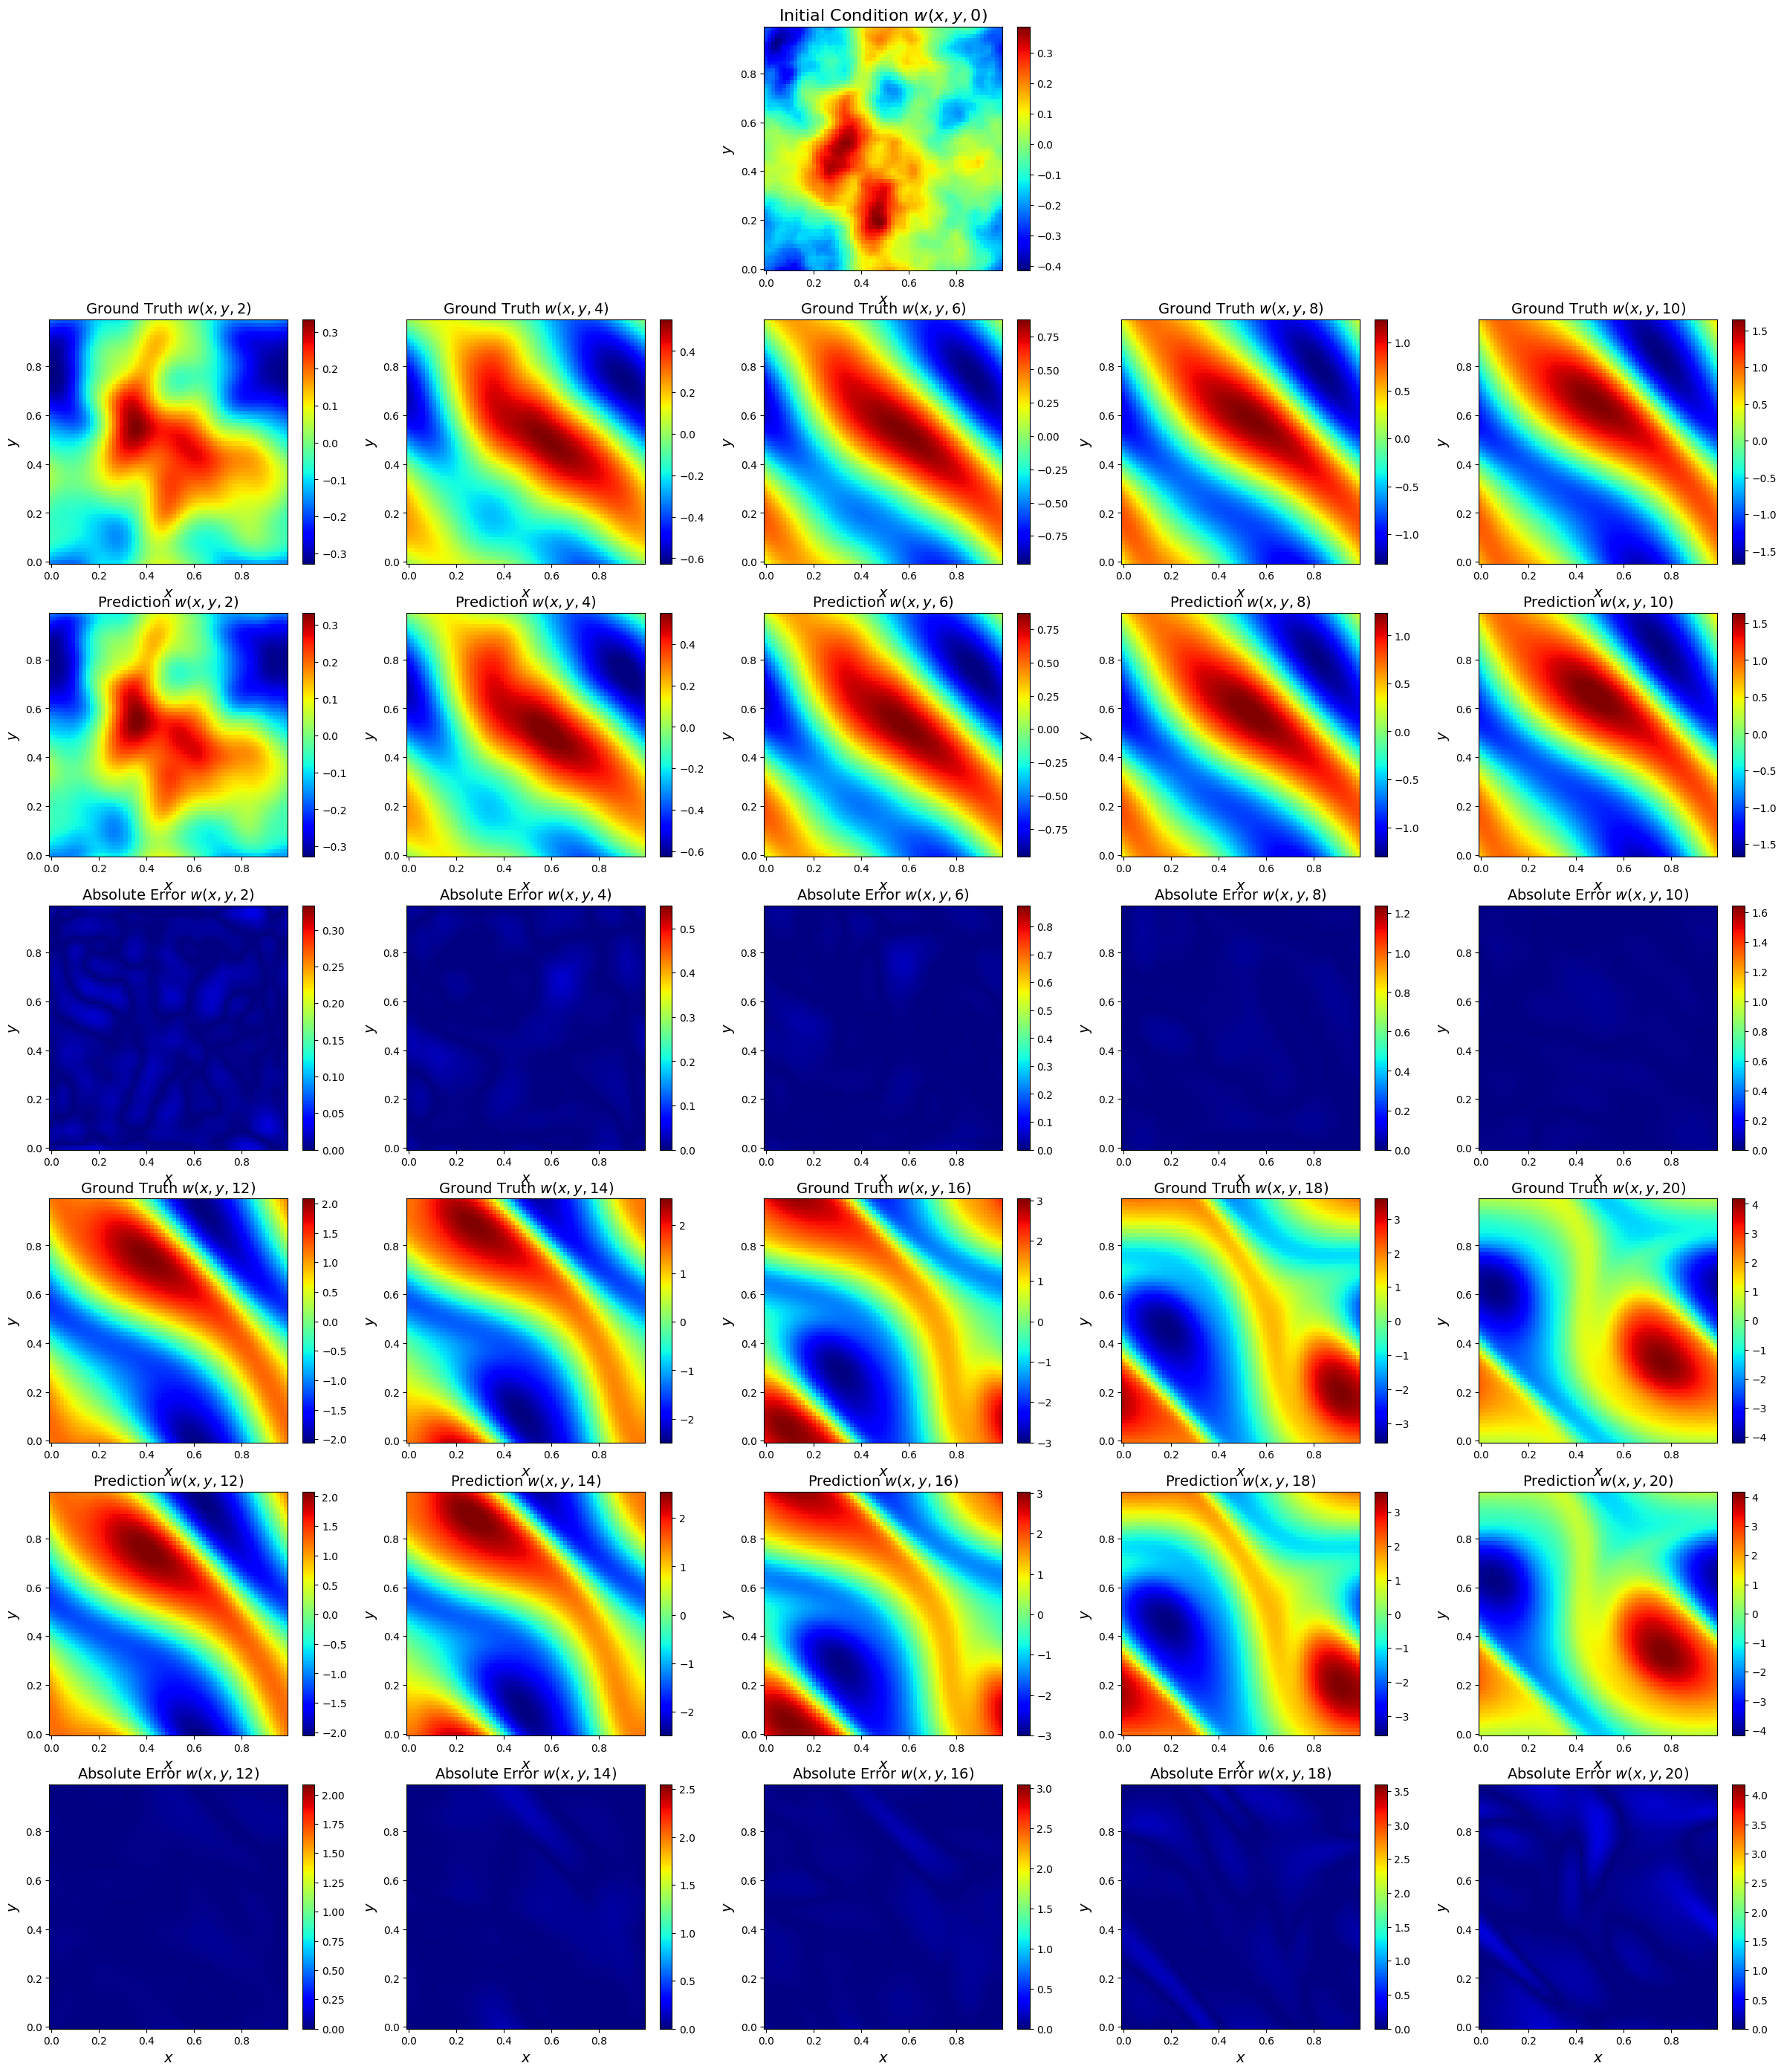

In [53]:
n = 1
fig, ax = plt.subplots(7, 5, figsize=(30, 35))
im1 = ax[0, 2].pcolormesh(X, Y, y[n], cmap='jet')
ax[0, 2].set_xlabel('$x$', fontsize=14)
ax[0, 2].set_ylabel('$y$', fontsize=14)
ax[0, 2].set_title('Initial Condition $w(x, y, 0)$', fontsize=16)
fig.colorbar(im1, ax=ax[0, 2])

ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 3].set_axis_off()
ax[0, 4].set_axis_off()

for i in range(5):
    norm1 = matplotlib.colors.Normalize(vmin=x[n, i*2+1].min(), vmax=x[n, i*2+1].max())
    im2 = ax[1, i].pcolormesh(X, Y, x[n, i*2+1], cmap='jet', norm=norm1)
    ax[1, i].set_xlabel('$x$', fontsize=14)
    ax[1, i].set_ylabel('$y$', fontsize=14)
    ax[1, i].set_title(f'Ground Truth $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, x_pred010_ec[n, i*2+1], cmap='jet', norm=norm1)
    ax[2, i].set_xlabel('$x$', fontsize=14)
    ax[2, i].set_ylabel('$y$', fontsize=14)
    ax[2, i].set_title(f'Prediction $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im3, ax=ax[2, i])

    norm2 = matplotlib.colors.Normalize(vmin=0, vmax=x[n, i*2+1].max())
    im4 = ax[3, i].pcolormesh(X, Y, np.abs(x[n, i*2+1] - x_pred010_ec[n, i*2+1]), cmap='jet', norm=norm2)
    ax[3, i].set_xlabel('$x$', fontsize=14)
    ax[3, i].set_ylabel('$y$', fontsize=14)
    ax[3, i].set_title(f'Absolute Error $w(x, y, {i*2+2})$', fontsize=14)
    fig.colorbar(im4, ax=ax[3, i])

    norm3 = matplotlib.colors.Normalize(vmin=x[n, i*2+11].min(), vmax=x[n, i*2+11].max())
    im5 = ax[4, i].pcolormesh(X, Y, x[n, i*2+11], cmap='jet', norm=norm3)
    ax[4, i].set_xlabel('$x$', fontsize=14)
    ax[4, i].set_ylabel('$y$', fontsize=14)
    ax[4, i].set_title(f'Ground Truth $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im5, ax=ax[4, i])

    im6 = ax[5, i].pcolormesh(X, Y, x_pred010_ec[n, i*2+11], cmap='jet', norm=norm3)
    ax[5, i].set_xlabel('$x$', fontsize=14)
    ax[5, i].set_ylabel('$y$', fontsize=14)
    ax[5, i].set_title(f'Prediction $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im6, ax=ax[5, i])

    norm4 = matplotlib.colors.Normalize(vmin=0, vmax=x[n, i*2+11].max())
    im7 = ax[6, i].pcolormesh(X, Y, np.abs(x[n, i*2+11] - x_pred010_ec[n, i*2+11]), cmap='jet', norm=norm4)
    ax[6, i].set_xlabel('$x$', fontsize=14)
    ax[6, i].set_ylabel('$y$', fontsize=14)
    ax[6, i].set_title(f'Absolute Error $w(x, y, {i*2+12})$', fontsize=14)
    fig.colorbar(im7, ax=ax[6, i])

In [54]:
fig.savefig('../assets/ns/ns_prediction3.png', dpi=300, bbox_inches='tight')

### Different Parameters Settings Comparison

In [7]:
def multi_prediction(diffusion_model, conds, physics_loss_weight, error_calibration=False):
    conds = torch.split(conds, 2, dim=0)
    x_preds = []
    for cond in conds:
        x_pred = make_prediction(diffusion_model, cond, physics_loss_weight, error_calibration)
        x_preds.append(x_pred.copy())

    return np.concatenate(x_preds, axis=0)

In [8]:
x = ds[150:158]['x']
y = ds[150:158]['y']

In [9]:
x_pred000 = make_prediction(diffuser, y, 0.0, False)
torch.cuda.empty_cache()
print("0.0 done")
x_pred010 = make_prediction(diffuser, y, 0.1, False)
torch.cuda.empty_cache()
print("0.1 done")
x_pred020 = make_prediction(diffuser, y, 0.2, False)
torch.cuda.empty_cache()
print("0.2 done")
x_pred050 = make_prediction(diffuser, y, 0.5, False)
torch.cuda.empty_cache()
print("0.5 done")
x_pred100 = make_prediction(diffuser, y, 1.0, False)
torch.cuda.empty_cache()
print("1.0 done")
x_pred000_cal = x_pred000
torch.cuda.empty_cache()
print("0.0 cal done")
x_pred010_cal = make_prediction(diffuser, y, 0.1, True)
torch.cuda.empty_cache()
print("0.1 cal done")
x_pred020_cal = make_prediction(diffuser, y, 0.2, True)
torch.cuda.empty_cache()
print("0.2 cal done")
x_pred050_cal = make_prediction(diffuser, y, 0.5, True)
torch.cuda.empty_cache()
print("0.5 cal done")
x_pred100_cal = make_prediction(diffuser, y, 1.0, True)
torch.cuda.empty_cache()
print("1.0 cal done")


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


0.0 done


DDPM sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


0.1 done


DDPM sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


0.2 done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


0.5 done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


1.0 done
0.0 cal done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


0.1 cal done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


0.2 cal done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


0.5 cal done


DDPM sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


1.0 cal done


In [11]:
x = x.squeeze()

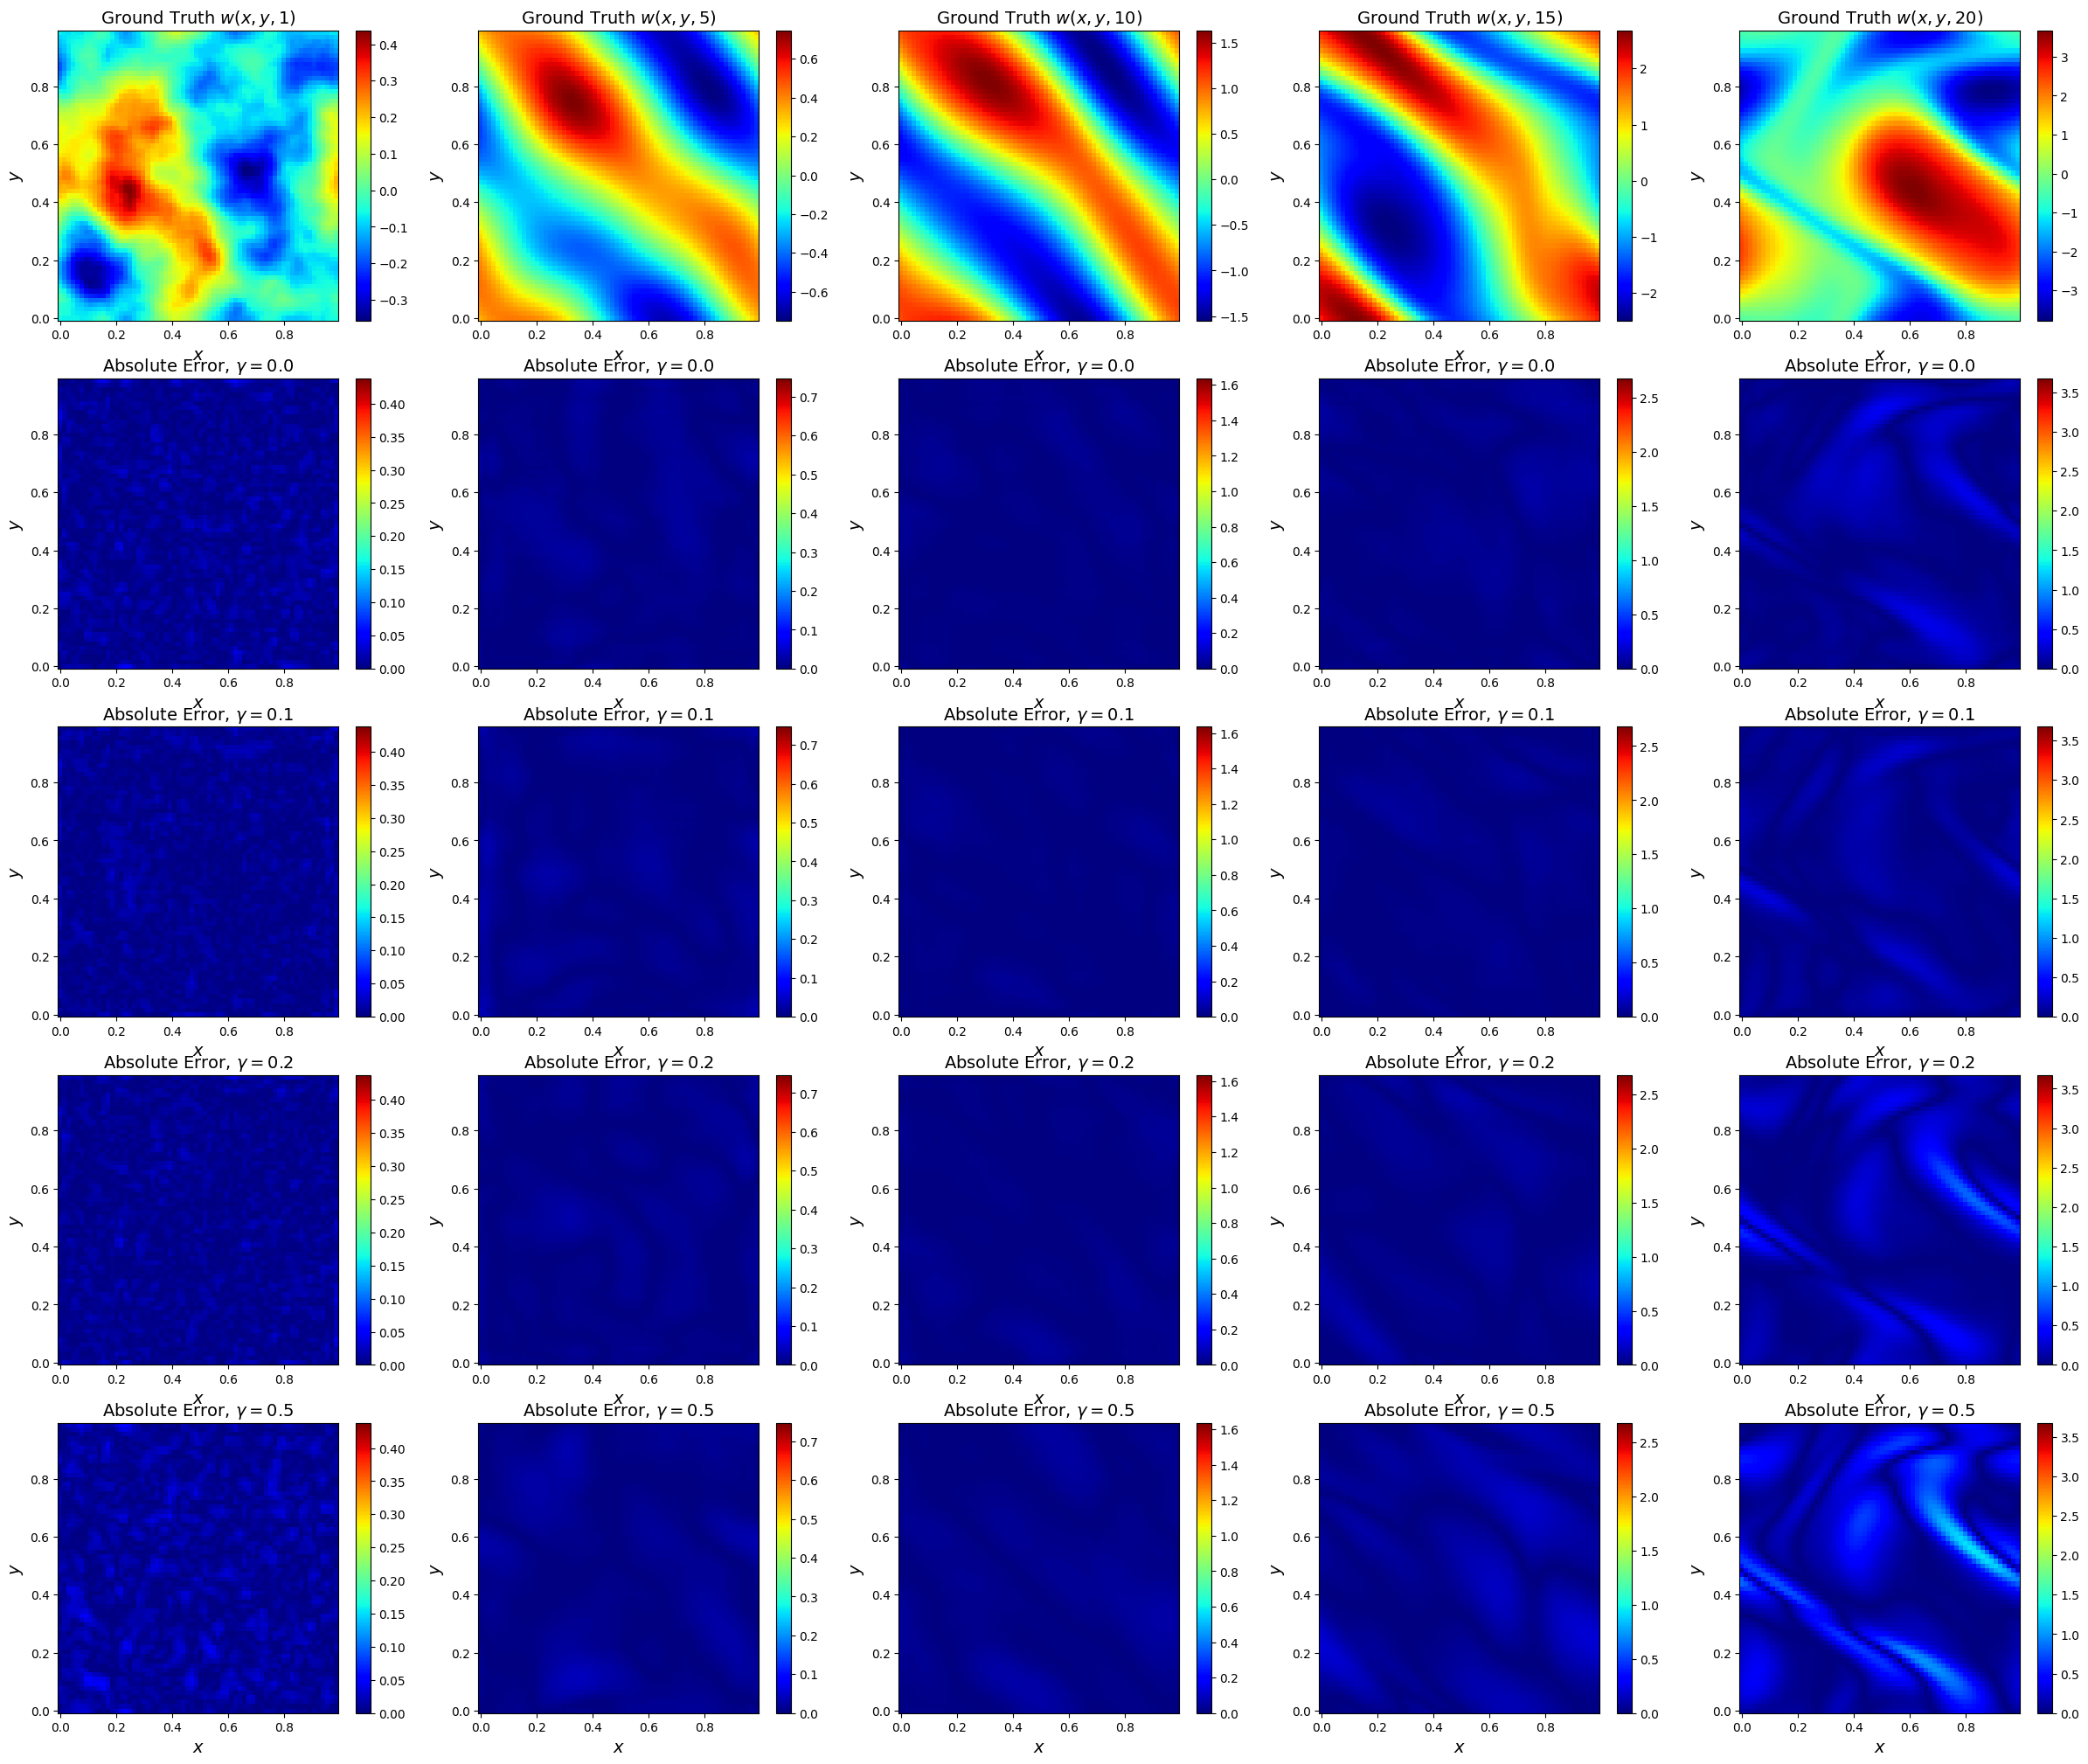

In [16]:
n = 1
fig, ax = plt.subplots(5, 5, figsize=(30, 25))
draw_idx = [0, 4, 9, 14, 19]
for i, idx in enumerate(draw_idx):
    im1 = ax[0, i].pcolormesh(X, Y, x[n, idx], cmap='jet')
    ax[0, i].set_xlabel('$x$', fontsize=14)
    ax[0, i].set_ylabel('$y$', fontsize=14)
    ax[0, i].set_title(f'Ground Truth $w(x, y, {idx+1})$', fontsize=14)
    fig.colorbar(im1, ax=ax[0, i])

    norm = matplotlib.colors.Normalize(vmin=0, vmax=x[n, idx].max())
    im2 = ax[1, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred000[n, idx]), cmap='jet', norm=norm)
    ax[1, i].set_xlabel('$x$', fontsize=14)
    ax[1, i].set_ylabel('$y$', fontsize=14)
    ax[1, i].set_title(fr'Absolute Error, $\gamma=0.0$', fontsize=14)
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred010[n, idx]), cmap='jet', norm=norm)
    ax[2, i].set_xlabel('$x$', fontsize=14)
    ax[2, i].set_ylabel('$y$', fontsize=14)
    ax[2, i].set_title(fr'Absolute Error, $\gamma=0.1$', fontsize=14)
    fig.colorbar(im3, ax=ax[2, i])

    im4 = ax[3, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred020[n, idx]), cmap='jet', norm=norm)
    ax[3, i].set_xlabel('$x$', fontsize=14)
    ax[3, i].set_ylabel('$y$', fontsize=14)
    ax[3, i].set_title(fr'Absolute Error, $\gamma=0.2$', fontsize=14)
    fig.colorbar(im4, ax=ax[3, i])

    im5 = ax[4, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred050[n, idx]), cmap='jet', norm=norm)
    ax[4, i].set_xlabel('$x$', fontsize=14)
    ax[4, i].set_ylabel('$y$', fontsize=14)
    ax[4, i].set_title(fr'Absolute Error, $\gamma=0.5$', fontsize=14)
    fig.colorbar(im5, ax=ax[4, i])

In [17]:
fig.savefig('../assets/ns/ns_parameters_comparison.png', dpi=300, bbox_inches='tight')

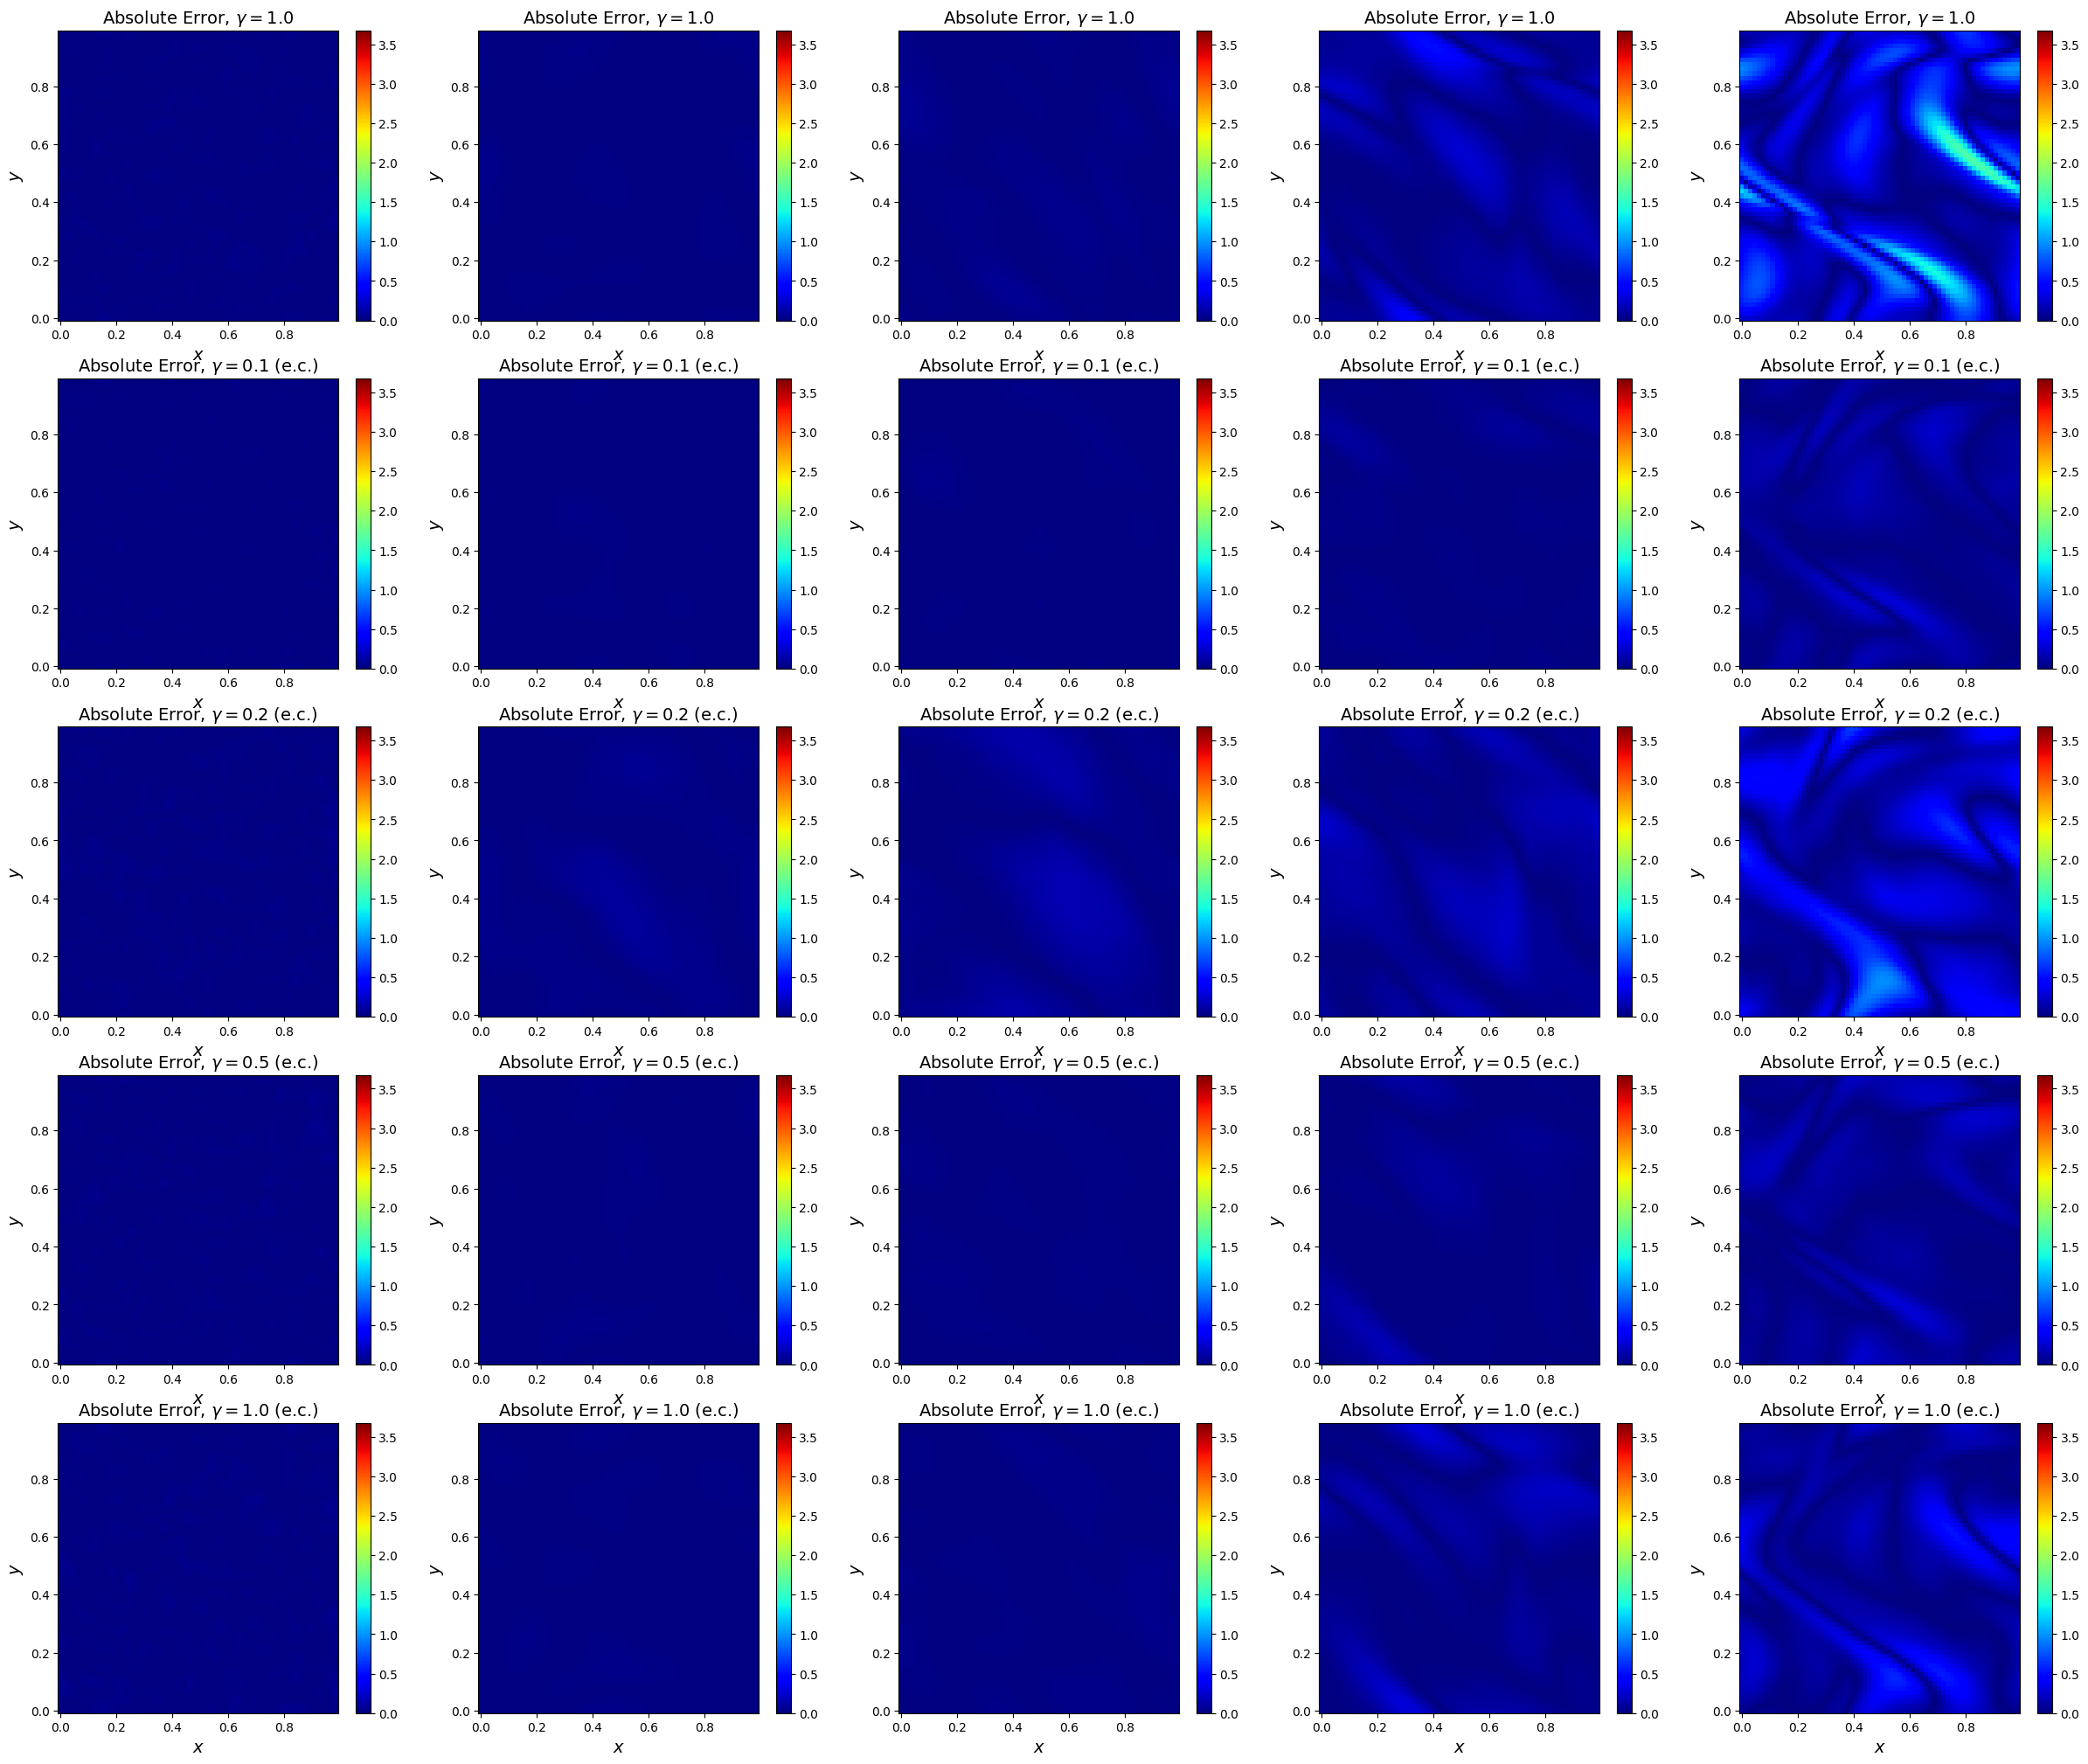

In [18]:
n = 1
fig, ax = plt.subplots(5, 5, figsize=(30, 25))
draw_idx = [0, 4, 9, 14, 19]
for i, idx in enumerate(draw_idx):    
    im6 = ax[0, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred100[n, idx]), cmap='jet', norm=norm)
    ax[0, i].set_xlabel('$x$', fontsize=14)
    ax[0, i].set_ylabel('$y$', fontsize=14)
    ax[0, i].set_title(fr'Absolute Error, $\gamma=1.0$', fontsize=14)
    fig.colorbar(im6, ax=ax[0, i])

    im7 = ax[1, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred010_cal[n, idx]), cmap='jet', norm=norm)
    ax[1, i].set_xlabel('$x$', fontsize=14)
    ax[1, i].set_ylabel('$y$', fontsize=14)
    ax[1, i].set_title(fr'Absolute Error, $\gamma=0.1$ (e.c.)', fontsize=14)
    fig.colorbar(im7, ax=ax[1, i])

    im8 = ax[2, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred020_cal[n, idx]), cmap='jet', norm=norm)
    ax[2, i].set_xlabel('$x$', fontsize=14)
    ax[2, i].set_ylabel('$y$', fontsize=14)
    ax[2, i].set_title(fr'Absolute Error, $\gamma=0.2$ (e.c.)', fontsize=14)
    fig.colorbar(im8, ax=ax[2, i])

    im9 = ax[3, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred050_cal[n, idx]), cmap='jet', norm=norm)
    ax[3, i].set_xlabel('$x$', fontsize=14)
    ax[3, i].set_ylabel('$y$', fontsize=14)
    ax[3, i].set_title(fr'Absolute Error, $\gamma=0.5$ (e.c.)', fontsize=14)
    fig.colorbar(im9, ax=ax[3, i])

    im10 = ax[4, i].pcolormesh(X, Y, np.abs(x[n, idx] - x_pred100_cal[n, idx]), cmap='jet', norm=norm)
    ax[4, i].set_xlabel('$x$', fontsize=14)
    ax[4, i].set_ylabel('$y$', fontsize=14)
    ax[4, i].set_title(fr'Absolute Error, $\gamma=1.0$ (e.c.)', fontsize=14)
    fig.colorbar(im10, ax=ax[4, i])

In [19]:
fig.savefig('../assets/ns/ns_parameters_comparison2.png', dpi=300, bbox_inches='tight')

In [31]:
x = x.numpy()

In [32]:
def cal_nRMSE(x, x_pred):
    norm1 = np.sqrt(np.sum((x-x_pred)**2, axis=(1, 2, 3)))
    norm2 = np.sqrt(np.sum(x**2, axis=(1, 2, 3)))
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [33]:
nRMSE000 = cal_nRMSE(x, x_pred000)
nRMSE010 = cal_nRMSE(x, x_pred010)
nRMSE020 = cal_nRMSE(x, x_pred020)
nRMSE050 = cal_nRMSE(x, x_pred050)
nRMSE100 = cal_nRMSE(x, x_pred100)
nRMSE000_cal = nRMSE000
nRMSE010_cal = cal_nRMSE(x, x_pred010_cal)
nRMSE020_cal = cal_nRMSE(x, x_pred020_cal)
nRMSE050_cal = cal_nRMSE(x, x_pred050_cal)
nRMSE100_cal = cal_nRMSE(x, x_pred100_cal)

In [34]:
print(f"nRMSE for 0.00 physics loss: {nRMSE000['mean']:.4f} ± {nRMSE000['std']:.4f}")
print(f"nRMSE for 0.10 physics loss: {nRMSE010['mean']:.4f} ± {nRMSE010['std']:.4f}")
print(f"nRMSE for 0.20 physics loss: {nRMSE020['mean']:.4f} ± {nRMSE020['std']:.4f}")
print(f"nRMSE for 0.50 physics loss: {nRMSE050['mean']:.4f} ± {nRMSE050['std']:.4f}")
print(f"nRMSE for 1.00 physics loss: {nRMSE100['mean']:.4f} ± {nRMSE100['std']:.4f}")
print(f"nRMSE for 0.00 physics loss (e.c.): {nRMSE000_cal['mean']:.4f} ± {nRMSE000_cal['std']:.4f}")
print(f"nRMSE for 0.10 physics loss (e.c.): {nRMSE010_cal['mean']:.4f} ± {nRMSE010_cal['std']:.4f}")
print(f"nRMSE for 0.20 physics loss (e.c.): {nRMSE020_cal['mean']:.4f} ± {nRMSE020_cal['std']:.4f}")
print(f"nRMSE for 0.50 physics loss (e.c.): {nRMSE050_cal['mean']:.4f} ± {nRMSE050_cal['std']:.4f}")
print(f"nRMSE for 1.00 physics loss (e.c.): {nRMSE100_cal['mean']:.4f} ± {nRMSE100_cal['std']:.4f}")

nRMSE for 0.00 physics loss: 0.0579 ± 0.0183
nRMSE for 0.10 physics loss: 0.0498 ± 0.0252
nRMSE for 0.20 physics loss: 0.0515 ± 0.0166
nRMSE for 0.50 physics loss: 0.0958 ± 0.0233
nRMSE for 1.00 physics loss: 0.1186 ± 0.0220
nRMSE for 0.00 physics loss (e.c.): 0.0579 ± 0.0183
nRMSE for 0.10 physics loss (e.c.): 0.0561 ± 0.0247
nRMSE for 0.20 physics loss (e.c.): 0.1124 ± 0.0171
nRMSE for 0.50 physics loss (e.c.): 0.0507 ± 0.0196
nRMSE for 1.00 physics loss (e.c.): 0.0717 ± 0.0239


In [35]:
def cal_bRMSE(x, x_pred):
    x_boundary = x.copy()
    x_boundary[:, :, 1:-1, 1:-1] = 0
    x_pred_boundary = x_pred.copy()
    x_pred_boundary[:, :, 1:-1, 1:-1] = 0
    norm1 = np.sqrt(np.sum((x_boundary-x_pred_boundary)**2, axis=(1, 2, 3)))
    norm2 = np.sqrt(np.sum(x_boundary**2, axis=(1, 2, 3)))
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [36]:
bRMSE000 = cal_bRMSE(x, x_pred000)
bRMSE010 = cal_bRMSE(x, x_pred010)
bRMSE020 = cal_bRMSE(x, x_pred020)
bRMSE050 = cal_bRMSE(x, x_pred050)
bRMSE100 = cal_bRMSE(x, x_pred100)
bRMSE000_cal = bRMSE000
bRMSE010_cal = cal_bRMSE(x, x_pred010_cal)
bRMSE020_cal = cal_bRMSE(x, x_pred020_cal)
bRMSE050_cal = cal_bRMSE(x, x_pred050_cal)
bRMSE100_cal = cal_bRMSE(x, x_pred100_cal)

In [37]:
print(f"bRMSE for 0.00 physics loss: {bRMSE000['mean']:.4f} ± {bRMSE000['std']:.4f}")
print(f"bRMSE for 0.10 physics loss: {bRMSE010['mean']:.4f} ± {bRMSE010['std']:.4f}")
print(f"bRMSE for 0.20 physics loss: {bRMSE020['mean']:.4f} ± {bRMSE020['std']:.4f}")
print(f"bRMSE for 0.50 physics loss: {bRMSE050['mean']:.4f} ± {bRMSE050['std']:.4f}")
print(f"bRMSE for 1.00 physics loss: {bRMSE100['mean']:.4f} ± {bRMSE100['std']:.4f}")
print(f"bRMSE for 0.00 physics loss (e.c.): {bRMSE000_cal['mean']:.4f} ± {bRMSE000_cal['std']:.4f}")
print(f"bRMSE for 0.10 physics loss (e.c.): {bRMSE010_cal['mean']:.4f} ± {bRMSE010_cal['std']:.4f}")
print(f"bRMSE for 0.20 physics loss (e.c.): {bRMSE020_cal['mean']:.4f} ± {bRMSE020_cal['std']:.4f}")
print(f"bRMSE for 0.50 physics loss (e.c.): {bRMSE050_cal['mean']:.4f} ± {bRMSE050_cal['std']:.4f}")
print(f"bRMSE for 1.00 physics loss (e.c.): {bRMSE100_cal['mean']:.4f} ± {bRMSE100_cal['std']:.4f}")

bRMSE for 0.00 physics loss: 0.0530 ± 0.0196
bRMSE for 0.10 physics loss: 0.0477 ± 0.0229
bRMSE for 0.20 physics loss: 0.0489 ± 0.0178
bRMSE for 0.50 physics loss: 0.0822 ± 0.0222
bRMSE for 1.00 physics loss: 0.1040 ± 0.0227
bRMSE for 0.00 physics loss (e.c.): 0.0530 ± 0.0196
bRMSE for 0.10 physics loss (e.c.): 0.0561 ± 0.0256
bRMSE for 0.20 physics loss (e.c.): 0.1043 ± 0.0186
bRMSE for 0.50 physics loss (e.c.): 0.0464 ± 0.0185
bRMSE for 1.00 physics loss (e.c.): 0.0686 ± 0.0246


In [43]:
def cal_temporal_abs_error(x, x_pred):
    norm1 = np.sqrt(np.sum((x-x_pred)**2, axis=(2, 3)))
    norm2 = np.sqrt(np.sum(x**2, axis=(2, 3)))
    mean = np.sqrt(norm1**2 / norm2**2).mean(axis=0)
    std = np.sqrt(norm1**2 / norm2**2).std(axis=0)
    return {'mean': mean, 'std': std}

In [44]:
t_nRMSE000 = cal_temporal_abs_error(x, x_pred000)
t_nRMSE010 = cal_temporal_abs_error(x, x_pred010)
t_nRMSE020 = cal_temporal_abs_error(x, x_pred020)
t_nRMSE050 = cal_temporal_abs_error(x, x_pred050)
t_nRMSE100 = cal_temporal_abs_error(x, x_pred100)
t_nRMSE000_cal = t_nRMSE000
t_nRMSE010_cal = cal_temporal_abs_error(x, x_pred010_cal)
t_nRMSE020_cal = cal_temporal_abs_error(x, x_pred020_cal)
t_nRMSE050_cal = cal_temporal_abs_error(x, x_pred050_cal)
t_nRMSE100_cal = cal_temporal_abs_error(x, x_pred100_cal)

In [46]:
t_range = np.arange(1, 21)

(1.0, 20.0)

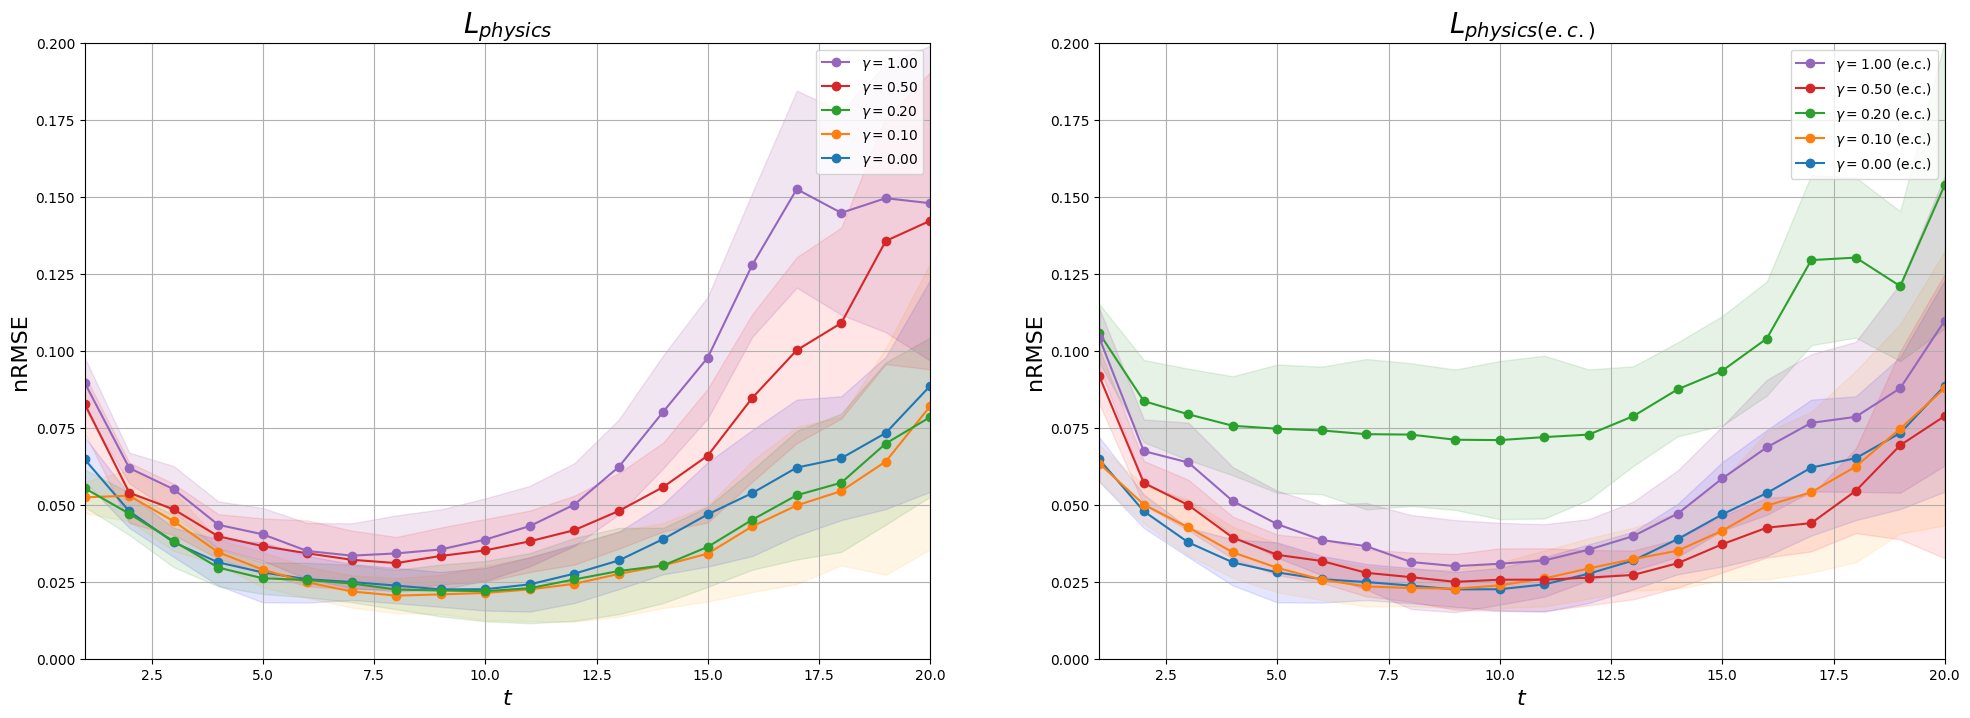

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].plot(t_range, t_nRMSE000['mean'], label=r'$\gamma=0.00$', marker='o')
ax[0].fill_between(t_range, t_nRMSE000['mean']-t_nRMSE000['std'], t_nRMSE000['mean']+t_nRMSE000['std'], color='blue', alpha=0.1)

ax[0].plot(t_range, t_nRMSE010['mean'], label=r'$\gamma=0.10$', marker='o')
ax[0].fill_between(t_range, t_nRMSE010['mean']-t_nRMSE010['std'], t_nRMSE010['mean']+t_nRMSE010['std'], color='orange', alpha=0.1)

ax[0].plot(t_range, t_nRMSE020['mean'], label=r'$\gamma=0.20$', marker='o')
ax[0].fill_between(t_range, t_nRMSE020['mean']-t_nRMSE020['std'], t_nRMSE020['mean']+t_nRMSE020['std'], color='green', alpha=0.1)

ax[0].plot(t_range, t_nRMSE050['mean'], label=r'$\gamma=0.50$', marker='o')
ax[0].fill_between(t_range, t_nRMSE050['mean']-t_nRMSE050['std'], t_nRMSE050['mean']+t_nRMSE050['std'], color='red', alpha=0.1)

ax[0].plot(t_range, t_nRMSE100['mean'], label=r'$\gamma=1.00$', marker='o')
ax[0].fill_between(t_range, t_nRMSE100['mean']-t_nRMSE100['std'], t_nRMSE100['mean']+t_nRMSE100['std'], color='purple', alpha=0.1)
ax[0].set_xlabel('$t$', fontsize=16)
ax[0].set_ylabel('nRMSE', fontsize=16)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='upper right')
ax[0].grid()
ax[0].set_ylim([0, 0.2])
ax[0].set_xlim([1, 20])
ax[0].set_title(r'$L_{physics}$', fontsize=20)
# set log scale to y axis

ax[1].plot(t_range, t_nRMSE000_cal['mean'], label=r'$\gamma=0.00$ (e.c.)', marker='o')
ax[1].fill_between(t_range, t_nRMSE000_cal['mean']-t_nRMSE000_cal['std'], t_nRMSE000_cal['mean']+t_nRMSE000_cal['std'], color='blue', alpha=0.1)

ax[1].plot(t_range, t_nRMSE010_cal['mean'], label=r'$\gamma=0.10$ (e.c.)', marker='o')
ax[1].fill_between(t_range, t_nRMSE010_cal['mean']-t_nRMSE010_cal['std'], t_nRMSE010_cal['mean']+t_nRMSE010_cal['std'], color='orange', alpha=0.1)

ax[1].plot(t_range, t_nRMSE020_cal['mean'], label=r'$\gamma=0.20$ (e.c.)', marker='o')
ax[1].fill_between(t_range, t_nRMSE020_cal['mean']-t_nRMSE020_cal['std'], t_nRMSE020_cal['mean']+t_nRMSE020_cal['std'], color='green', alpha=0.1)

ax[1].plot(t_range, t_nRMSE050_cal['mean'], label=r'$\gamma=0.50$ (e.c.)', marker='o')
ax[1].fill_between(t_range, t_nRMSE050_cal['mean']-t_nRMSE050_cal['std'], t_nRMSE050_cal['mean']+t_nRMSE050_cal['std'], color='red', alpha=0.1)

ax[1].plot(t_range, t_nRMSE100_cal['mean'], label=r'$\gamma=1.00$ (e.c.)', marker='o')
ax[1].fill_between(t_range, t_nRMSE100_cal['mean']-t_nRMSE100_cal['std'], t_nRMSE100_cal['mean']+t_nRMSE100_cal['std'], color='purple', alpha=0.1)

ax[1].set_xlabel('$t$', fontsize=16)
ax[1].set_ylabel('nRMSE', fontsize=16)
ax[1].set_title(r'$L_{physics(e.c.)}$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], loc='upper right')
ax[1].grid()
ax[1].set_ylim([0, 0.2])
ax[1].set_xlim([1, 20])

In [55]:
fig.savefig('../assets/ns/ns_temporal_nRMSE.png', dpi=300, bbox_inches='tight')

### Physics Loss

In [56]:
def naiver_stokes_residual(w, w_prev, w_next, visc, dt):
    _, _, nx, ny = w.shape

    # Wavenumbers in Fourier space
    k_max = nx // 2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1), \
                      torch.arange(start=-k_max, end=0, step=1)), 0). \
                        reshape(nx, 1).repeat(1, ny).reshape(1, 1, nx, ny)
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1), \
                      torch.arange(start=-k_max, end=0, step=1)), 0). \
                        reshape(1, ny).repeat(nx, 1).reshape(1, 1, nx, ny)

    # Laplacian in Fourier space
    lap = (k_x ** 2 + k_y ** 2)
    lap[..., 0, 0] = 1.0

    def cal_residual(w, f):
        w_h = torch.fft.fft2(w, dim=[-2, -1])
        psi_h = w_h / lap

        # Velocity field in Fourier space
        u_h = 1j * k_y * psi_h
        v_h = -1j * k_x * psi_h
        wx_h = 1j * k_x * w_h
        wy_h = 1j * k_y * w_h
        lap_w_h = - lap * w_h

        # Calculate velocity field in physical space
        u = torch.fft.ifft2(u_h[..., :k_max + 1, :, :], dim=[-2, -1]).real
        v = torch.fft.ifft2(v_h[..., :k_max + 1, :, :], dim=[-2, -1]).real
        wx = torch.fft.ifft2(wx_h[..., :k_max + 1, :, :], dim=[-2, -1]).real
        wy = torch.fft.ifft2(wy_h[..., :k_max + 1, :, :], dim=[-2, -1]).real
        lap_w = torch.fft.ifft2(lap_w_h[..., :k_max + 1, :, :], dim=[-2, -1]).real
        
        advection = u * wx + v * wy

        # Centeral difference in time
        wt = (w_next - w_prev) / (2 * dt)

        res = wt + (advection - visc * lap_w) - f

        return res

    # Force term
    x = torch.linspace(0., 1., nx+1)
    x = x[0:-1]
    X, Y = torch.meshgrid(x, x, indexing='ij')
    f = 0.1 * (torch.sin(2 * torch.pi * (X + Y)) + torch.cos(2 * torch.pi * (X + Y)))

    res_w = cal_residual(w, f)
    loss = torch.mean(res_w ** 2, dim=(1, 2, 3))
    
    mean = loss.mean(dim=0)
    std = loss.std(dim=0)

    return {'mean': mean, 'std': std}

In [57]:
x_prev = ds[150:158]['x_prev']
x_next = ds[150:158]['x_next']

In [58]:
x_prev = x_prev.squeeze()
x_next = x_next.squeeze()

In [59]:
x_phy = naiver_stokes_residual(torch.from_numpy(x), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred000_phy = naiver_stokes_residual(torch.from_numpy(x_pred000), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred010_phy = naiver_stokes_residual(torch.from_numpy(x_pred010), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred020_phy = naiver_stokes_residual(torch.from_numpy(x_pred020), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred050_phy = naiver_stokes_residual(torch.from_numpy(x_pred050), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred100_phy = naiver_stokes_residual(torch.from_numpy(x_pred100), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred000_cal_phy = x_pred000_phy
x_pred010_cal_phy = naiver_stokes_residual(torch.from_numpy(x_pred010_cal), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred020_cal_phy = naiver_stokes_residual(torch.from_numpy(x_pred020_cal), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred050_cal_phy = naiver_stokes_residual(torch.from_numpy(x_pred050_cal), x_prev, x_next, visc=1e-3, dt=1e-3)
x_pred100_cal_phy = naiver_stokes_residual(torch.from_numpy(x_pred100_cal), x_prev, x_next, visc=1e-3, dt=1e-3)

In [60]:
print(f"Physics loss reference: {x_phy['mean']:.4f} ± {x_phy['std']:.4f}")
print(f"Physics loss for 0.00 physics loss: {x_pred000_phy['mean']:.4f} ± {x_pred000_phy['std']:.4f}")
print(f"Physics loss for 0.10 physics loss: {x_pred010_phy['mean']:.4f} ± {x_pred010_phy['std']:.4f}")
print(f"Physics loss for 0.20 physics loss: {x_pred020_phy['mean']:.4f} ± {x_pred020_phy['std']:.4f}")
print(f"Physics loss for 0.50 physics loss: {x_pred050_phy['mean']:.4f} ± {x_pred050_phy['std']:.4f}")
print(f"Physics loss for 1.00 physics loss: {x_pred100_phy['mean']:.4f} ± {x_pred100_phy['std']:.4f}")
print(f"Physics loss for 0.00 physics loss (e.c.): {x_pred000_cal_phy['mean']:.4f} ± {x_pred000_cal_phy['std']:.4f}")
print(f"Physics loss for 0.10 physics loss (e.c.): {x_pred010_cal_phy['mean']:.4f} ± {x_pred010_cal_phy['std']:.4f}")
print(f"Physics loss for 0.20 physics loss (e.c.): {x_pred020_cal_phy['mean']:.4f} ± {x_pred020_cal_phy['std']:.4f}")
print(f"Physics loss for 0.50 physics loss (e.c.): {x_pred050_cal_phy['mean']:.4f} ± {x_pred050_cal_phy['std']:.4f}")
print(f"Physics loss for 1.00 physics loss (e.c.): {x_pred100_cal_phy['mean']:.4f} ± {x_pred100_cal_phy['std']:.4f}")

Physics loss reference: 0.0201 ± 0.0016
Physics loss for 0.00 physics loss: 0.0421 ± 0.0153
Physics loss for 0.10 physics loss: 0.0306 ± 0.0157
Physics loss for 0.20 physics loss: 0.0248 ± 0.0103
Physics loss for 0.50 physics loss: 0.0305 ± 0.0112
Physics loss for 1.00 physics loss: 0.0386 ± 0.0228
Physics loss for 0.00 physics loss (e.c.): 0.0421 ± 0.0153
Physics loss for 0.10 physics loss (e.c.): 0.0358 ± 0.0164
Physics loss for 0.20 physics loss (e.c.): 0.0735 ± 0.0334
Physics loss for 0.50 physics loss (e.c.): 0.0287 ± 0.0078
Physics loss for 1.00 physics loss (e.c.): 0.0288 ± 0.0141
